In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sklearn.metrics import mean_squared_error
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.base import ForecastingHorizon
from sklearn.neural_network import MLPRegressor
import itertools
import torch
import torch.nn as nn
import ast


from Forcasting_lib import load_fred_data, make_stationary, standardize_data

In [ ]:
## load and transform data
df, transform_codes = load_fred_data()
df_stationary = make_stationary(df, transform_codes)

cols_to_standardize = [
    'GDPC1',      # Reales BIP
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel  #fehlt ein Wert 
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500'       # S&P 500 Index
]


df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

Datei 'current.csv' gefunden. Lade lokal...
Daten erfolgreich vorbereitet.
Standardisierung abgeschlossen.


In [ ]:
## Daten vorbereiten
data_all = df_std[cols_to_standardize].dropna()

# Ziel und Prädiktoren trennen
y_all = data_all["GDPC1"]
X_all = data_all.drop(columns=["GDPC1"])  

y_all = y_all.reset_index(drop=True)
X_all = X_all.reset_index(drop=True)

In [4]:
def evaluate_FF_expanding_window(y_all, X_all, initial_window=100, window_length=5,
                                  hidden_layer_sizes=(20,), learning_rate_init=0.001, alpha=0.001):
    y_preds = []
    y_trues = []

    n_obs = len(y_all)

    # Preconstruct lagged feature matrix
    lagged_X = []
    target_y = []

    for t in range(window_length, n_obs):
        x_window = X_all.iloc[t - window_length:t].values.flatten()
        lagged_X.append(x_window)
        target_y.append(y_all.iloc[t])

    lagged_X = np.array(lagged_X)
    target_y = np.array(target_y)

    # Now do expanding window loop
    for i in range(initial_window - window_length, len(target_y) - 1):
        X_train = lagged_X[:i]
        y_train = target_y[:i]

        X_test = lagged_X[i + 1].reshape(1, -1)
        y_test = target_y[i + 1]

        model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                             alpha=alpha,
                             learning_rate_init=learning_rate_init,
                             max_iter=1000,
                             random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]

        y_preds.append(y_pred)
        y_trues.append(y_test)

    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    return rmse, y_preds, y_trues


In [ ]:
## Implementiert Dropout um Unsicherheit zu quantifizieren
class MCDropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes=(20,), dropout_rate=0.2):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layer_sizes:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def evaluate_FF_MC_dropout(y_all, X_all, initial_window=100, window_length=5,
                           hidden_layer_sizes=(20,), learning_rate=0.001,
                           alpha=0.001, dropout_rate=0.2, n_mc_samples=100):
    """ 
    Evaluate a feedforward neural network with MC Dropout for uncertainty quantification.
    Uses 95% confidence intervals for predictions.
    Returns: rmse, y_preds, y_trues, lower_bounds, upper_bounds
    """
    
    y_preds = []
    y_trues = []
    lower_bounds = []
    upper_bounds = []

    n_obs = len(y_all)

    # Lag-Feature-Engineering
    lagged_X, target_y = [], []
    for t in range(window_length, n_obs):
        x_window = X_all.iloc[t - window_length:t].values.flatten()
        lagged_X.append(x_window)
        target_y.append(y_all.iloc[t])
    lagged_X = np.array(lagged_X)
    target_y = np.array(target_y)

    for i in range(initial_window - window_length, len(target_y) - 1):
        X_train = lagged_X[:i]
        y_train = target_y[:i]

        X_test = lagged_X[i + 1].reshape(1, -1)
        y_test = target_y[i + 1]

        # Modell initialisieren
        model = MCDropoutMLP(input_dim=X_train.shape[1],
                             hidden_layer_sizes=hidden_layer_sizes,
                             dropout_rate=dropout_rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha)
        loss_fn = nn.MSELoss()

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

        model.train()
        for _ in range(200):  # Trainingsiterationszahl
            optimizer.zero_grad()
            output = model(X_train_t)
            loss = loss_fn(output, y_train_t)
            loss.backward()
            optimizer.step()

        # MC Dropout aktiv lassen
        model.train()

        X_test_t = torch.tensor(X_test, dtype=torch.float32)
        preds = []
        for _ in range(n_mc_samples):
            with torch.no_grad():
                pred = model(X_test_t).item()
                preds.append(pred)

        preds = np.array(preds)
        y_preds.append(preds.mean())
        y_trues.append(y_test)

        # 95%-Konfidenzintervall
        lower = np.percentile(preds, 2.5)
        upper = np.percentile(preds, 97.5)
        lower_bounds.append(lower)
        upper_bounds.append(upper)

    rmse = np.sqrt(mean_squared_error(y_trues, y_preds))
    return rmse, y_preds, y_trues, lower_bounds, upper_bounds


NameError: name 'nn' is not defined

In [16]:
rmse, y_preds, y_trues = evaluate_FF_expanding_window(y_all, X_all, initial_window=100, window_length=5, hidden_layer_sizes=20, alpha=0.001)

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

### USe Grid search to find best hyperparameters

In [29]:
## erzeuge durch Iteration alle Kombinationen der Hyperparameter 
param_grid = {
    'window_length': [1,2,3,4,5],
    'hidden_layer_sizes': [(20,), (35,)],
    'alpha': [0.0001, 0.001, 0.01]
}

param_grid = list(itertools.product(*param_grid.values()))

In [49]:
results = []
for window_length, hidden_layer_sizes, alpha in param_grid:
    rmse, y_trues, y_preds = evaluate_FF_expanding_window(y_all[:150], 
                                                    X_all[:150], 
                                                    initial_window=100, 
                                                    window_length=window_length, 
                                                    hidden_layer_sizes=hidden_layer_sizes, 
                                                    alpha=alpha)
    rmse = np.sqrt(mean_squared_error(y_trues[-50:], y_preds[-50:]))
    print(f"Params: window_length={window_length}, hidden_layer_sizes={hidden_layer_sizes}, alpha={alpha}, RMSE: {rmse:.3f}")
    results.append(((window_length, hidden_layer_sizes, alpha), rmse))

/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

Params: window_length=1, hidden_layer_sizes=(20,), alpha=0.0001, RMSE: 0.534


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

Params: window_length=1, hidden_layer_sizes=(20,), alpha=0.001, RMSE: 0.535


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

Params: window_length=1, hidden_layer_sizes=(20,), alpha=0.01, RMSE: 0.534


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

Params: window_length=1, hidden_layer_sizes=(35,), alpha=0.0001, RMSE: 0.637


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

Params: window_length=1, hidden_layer_sizes=(35,), alpha=0.001, RMSE: 0.637


/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/philippgodde/miniforge3/envs/g/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

Params: window_length=1, hidden_layer_sizes=(35,), alpha=0.01, RMSE: 0.608
Params: window_length=2, hidden_layer_sizes=(20,), alpha=0.0001, RMSE: 0.585
Params: window_length=2, hidden_layer_sizes=(20,), alpha=0.001, RMSE: 0.585
Params: window_length=2, hidden_layer_sizes=(20,), alpha=0.01, RMSE: 0.584
Params: window_length=2, hidden_layer_sizes=(35,), alpha=0.0001, RMSE: 0.691
Params: window_length=2, hidden_layer_sizes=(35,), alpha=0.001, RMSE: 0.692
Params: window_length=2, hidden_layer_sizes=(35,), alpha=0.01, RMSE: 0.687
Params: window_length=3, hidden_layer_sizes=(20,), alpha=0.0001, RMSE: 0.732
Params: window_length=3, hidden_layer_sizes=(20,), alpha=0.001, RMSE: 0.732
Params: window_length=3, hidden_layer_sizes=(20,), alpha=0.01, RMSE: 0.727
Params: window_length=3, hidden_layer_sizes=(35,), alpha=0.0001, RMSE: 0.722
Params: window_length=3, hidden_layer_sizes=(35,), alpha=0.001, RMSE: 0.721
Params: window_length=3, hidden_layer_sizes=(35,), alpha=0.01, RMSE: 0.710
Params: windo

In [ ]:
## Speichere Hyperparameter für Spätere Verwedungung 
df = pd.DataFrame([
    {
        "window_length": params[0],
        "hidden_layer_sizes": params[1],
        "alpha": params[2],
        "rmse": rmse
    }
    for params, rmse in results
])

df.to_csv("./Data/FF_NN_Hyper_results.csv", index=False)


In [ ]:
## Lade optimierte Hyperparameter
results = pd.read_csv("./Data/FF_NN_Hyper_results.csv")
best_params  = results.loc[results['rmse'].idxmin()]
print(f"Best parameter combination: window_length={best_params[0]}, hidden_layer_sizes={best_params[1]}, alpha={best_params[2]},  RMSE={best_params[3]:.4f}")

Best parameter combination: window_length=1, hidden_layer_sizes=(20,), alpha=0.0001,  RMSE=0.5340


/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_29603/2739335073.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Best parameter combination: window_length={best_params[0]}, hidden_layer_sizes={best_params[1]}, alpha={best_params[2]},  RMSE={best_params[3]:.4f}")


### Make Final Prediction

In [ ]:
rmse, y_preds, y_trues  = evaluate_FF_expanding_window(
        y_all = y_all, 
        X_all = X_all, 
        initial_window = 150,  ## need to be 150 
        window_length = best_params[0], 
        hidden_layer_sizes = ast.literal_eval(best_params[1]), 
        alpha = float(best_params[2]))

# Calculate RMSE using only data from index 151 onward
print(f"RMSE (for the test set): {rmse:.4f}")

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_8318/2233329496.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = best_params[0],
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_8318/2233329496.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hidden_layer_sizes = ast.literal_eval(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_8318/2233329496.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

RMSE (for the test set): 1.4238


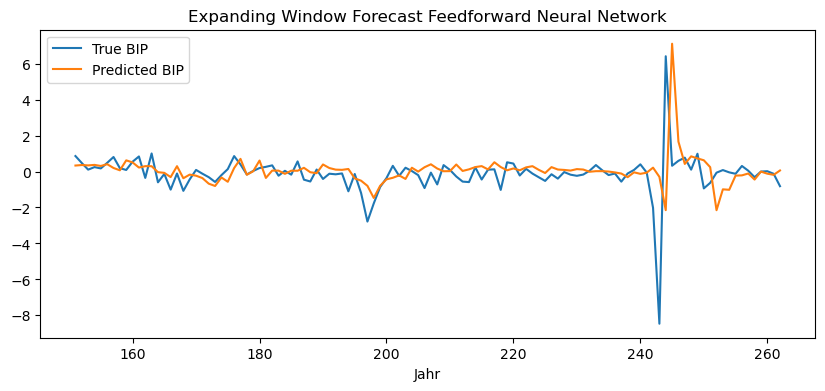

RMSE: 1.424


In [57]:
# Auswertung
dates = y_all.index[-len(y_preds):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
plt.title("Expanding Window Forecast Feedforward Neural Network")
plt.savefig("./plots/final_forecast_FF.png")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

In [58]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date': df_std.index[-len(y_preds):],
    'y_true': y_trues,
    'y_pred': y_preds
})
results_df.to_csv('./Data/results/FF_NN_forecast_results.csv', index=True)

### Prognose mit Konfidenzintervallen

In [10]:
rsme, y_preds, y_trues, lower_bounds, upper_bounds = evaluate_FF_MC_dropout(
    y_all=y_all,
    X_all=X_all,
    initial_window=150,  # need to be 150
    window_length=best_params[0],
    hidden_layer_sizes=ast.literal_eval(best_params[1]),
    alpha=float(best_params[2]))

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_29603/3996445589.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length=best_params[0],
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_29603/3996445589.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hidden_layer_sizes=ast.literal_eval(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_29603/3996445589.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

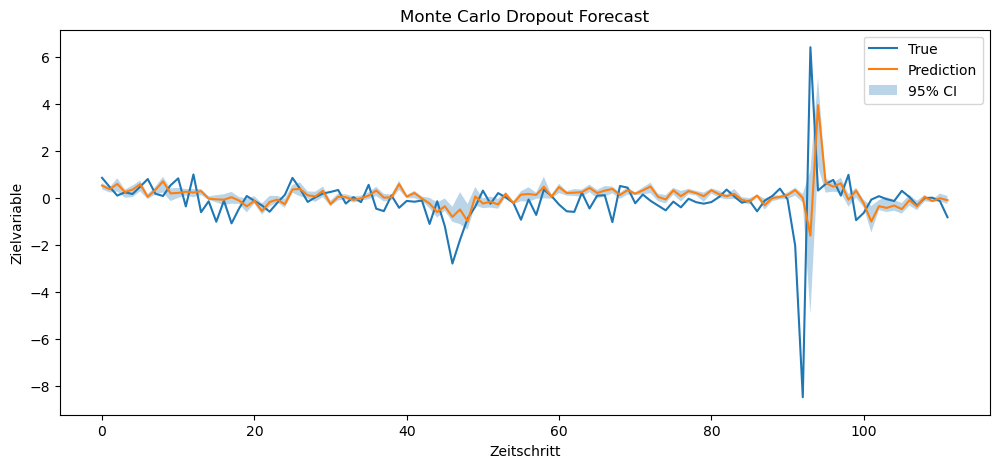

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(y_trues, label="True")
plt.plot(y_preds, label="Prediction")
plt.fill_between(range(len(y_preds)), lower_bounds, upper_bounds, alpha=0.3, label="95% CI")
plt.legend()
plt.title("Monte Carlo Dropout Forecast")
plt.xlabel("Zeitschritt")
plt.ylabel("Zielvariable")
plt.show()

In [12]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date': df_std.index[-len(y_preds):],
    'y_true': y_trues,
    'y_pred': y_preds,
    'lower_bound': lower_bounds,
    'upper_bound': upper_bounds
    
})
results_df.to_csv('./Data/results/FF_NN_forecast_results_CI.csv', index=True)

### Nutze erweiterten Prädiktorensatz

In [13]:
cols_to_standardize = [
    'GDPC1',      # Reales BIP, Zielvariable
    'UNRATE',     # Arbeitslosenquote
    'FEDFUNDS',   # Federal Funds Rate
    'CPILFESL',   # Verbraucherpreisindex ohne Energie und Nahrungsmittel
    'PAYEMS',     # Beschäftigte außerhalb der Landwirtschaft
    'GS10',       # Rendite 10-jähriger Staatsanleihen
    'TB3MS',       # Rendite 3-monatiger Staatsanleihen
    'M2REAL',     # Reale Geldmenge M2
    'S&P 500',    # S&P 500 Index
    'PCECC96',    # PCE-Kerninflation
    'GPDIC1',     # Bruttoinlandsinvestitionen (real)
    'PNFIx',      # Private nichtwohnwirtschaftliche Investitionen
    'FPIx',       # Ausrüstungsinvestitionen
    'PCDGx',      # Konsum langlebiger Güter
    'PCNDx',      # Konsum nicht langlebiger Güter
    'PCESVx',     # Konsum von Dienstleistungen
    'CE16OV',     # Zivilbeschäftigung
    'CPIAUCSL',   # Verbraucherpreisindex (CPI)
    'PCEPILFE'    # PCE-Kerninflation
]


df_std, scaler = standardize_data(df_stationary, cols_to_standardize)

## Daten vorbereiten
data_all = df_std[cols_to_standardize].dropna()

# Ziel und Prädiktoren trennen
y_all = data_all["GDPC1"]
X_all = data_all.drop(columns=["GDPC1"])  # <- Datum explizit entfernen

# Index zurücksetzen (optional, zur Sicherheit)
y_all = y_all.reset_index(drop=True)
X_all = X_all.reset_index(drop=True)

Standardisierung abgeschlossen.


In [60]:
rmse, y_preds, y_trues = evaluate_FF_expanding_window(
        y_all = y_all, 
        X_all = X_all, 
        initial_window = 150,  ## need to be 150 
        window_length = best_params[0], 
        hidden_layer_sizes = ast.literal_eval(best_params[1]), 
        alpha = float(best_params[2]))  

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_8318/4139608701.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length = best_params[0],
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_8318/4139608701.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hidden_layer_sizes = ast.literal_eval(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_8318/4139608701.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by 

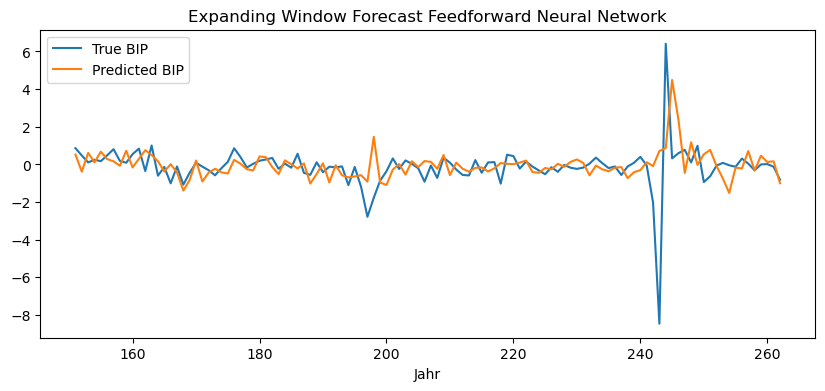

RMSE: 1.289


In [61]:
# Auswertung
dates = y_all.index[-len(y_preds):]  # Get the corresponding dates for the predictions
plt.figure(figsize=(10, 4))
plt.plot(dates, y_trues, label='True BIP')
plt.plot(dates, y_preds, label='Predicted BIP')
plt.xlabel("Jahr")
plt.legend()
plt.title("Expanding Window Forecast Feedforward Neural Network")
#plt.savefig("./plots/final_forecast_2_FF.png")
plt.show()

rmse = np.sqrt(mean_squared_error(y_preds, y_trues))
print(f"RMSE: {rmse:.3f}")

In [62]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date': df_std.index[-len(y_preds):],
    'y_true': y_trues,
    'y_pred': y_preds
})
results_df.to_csv('./Data/results/FF_NN_forecast_2_results.csv', index=True)

### Erweiterung um Konfidenzinteravelle zu erhalten

In [14]:
rsme, y_preds, y_trues, lower_bounds, upper_bounds = evaluate_FF_MC_dropout(
    y_all=y_all,
    X_all=X_all,
    initial_window=150,  # need to be 150
    window_length=best_params[0],
    hidden_layer_sizes=ast.literal_eval(best_params[1]),
    alpha=float(best_params[2]))

/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_29603/3996445589.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_length=best_params[0],
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_29603/3996445589.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hidden_layer_sizes=ast.literal_eval(best_params[1]),
/var/folders/01/0kkk3sm55p5_dtxnk5www9r00000gn/T/ipykernel_29603/3996445589.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

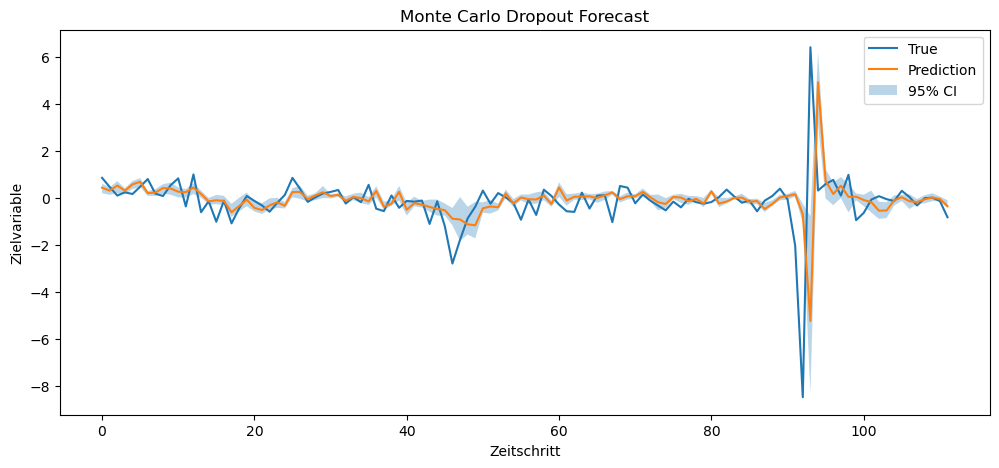

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_trues, label="True")
plt.plot(y_preds, label="Prediction")
plt.fill_between(range(len(y_preds)), lower_bounds, upper_bounds, alpha=0.3, label="95% CI")
plt.legend()
plt.title("Monte Carlo Dropout Forecast")
plt.xlabel("Zeitschritt")
plt.ylabel("Zielvariable")
plt.show()

In [16]:
# Speichern der Vorhersage- und True-Werte in einer CSV-Datei
results_df = pd.DataFrame({
    'date': df_std.index[-len(y_preds):],
    'y_true': y_trues,
    'y_pred': y_preds,
    'lower_bound': lower_bounds,
    'upper_bound': upper_bounds
    
})
results_df.to_csv('./Data/results/FF_NN_forecast_results_CI_2.csv', index=True)